## Parameters to tune for LAI

- `BaseT`
- `BaseTe`
- `GDDFUll`
- `SDDFull`
- `LAIMAX`
- `LAIMin`

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path
import supy as sp
import os
from shutil import copyfile
import geopandas as gpd
import pickle

In [61]:
def modify_attr(df_state_init,df):
    df_state_init.loc[:,'emissionsmethod']=0
    df_state_init.loc[:,'sfr']=[0.0, #Paved
                            0.0, #Bldg
                            1.0, #EveTr
                            0.0, #DecTr
                            0.0, #Grass
                            0.0, #Bsoil
                            0.0] #Water
    df_state_init.loc[:,'lat']=df.Latitude.values[0].values[0]
    df_state_init.loc[:,'lng']=df.Longitude.values[0].values[0]
    
    df_state_init.loc[:,'laimin']=[0.75,0.5,1.6]
    df_state_init.loc[:,'laimax']=[2.2,5,5.9]
    df_state_init.loc[:,'gddfull']=[450,450,450]
    df_state_init.loc[:,'sddfull']=[-370,-370,-370]
    df_state_init.loc[:,'basete']=[13,13,13]
    df_state_init.loc[:,'baset']=[5,5,5]
    
    df_state_init.lai_id = df_state_init.loc[:,'laimin']
    
    return df_state_init

def func_parse_date(year, doy, hour, min):
        dt = pd.to_datetime(' '.join(
            [str(k) for k in [year, doy, hour, min]]),
            format='%Y %j %H %M')
        return dt

def read_data(year,name):
    
    df=pd.read_csv('MODIS_LAI_AmeriFlux/statistics_Lai_500m-'+name+'.csv')
    df.columns=['product']+[i.split(' ')[1] for i in df.columns if i!='product']
    df=df.filter(['modis_date','value_mean'])

    df_period=df[[i.startswith('A'+str(year)) for i in df.modis_date]]
    df_period.loc[:,'DOY']=[int(i.split('A'+str(year))[1]) for i in df_period.modis_date]
    df_period=df_period.set_index('DOY')
    
    copyfile("./runs/data/"+name+"_"+str(year)+"_data_60.txt", "runs/run/input/Kc_2012_data_60.txt")
    df_forcing=pd.read_csv('runs/run'+'/Input/'+'kc'+'_'+'2012'+'_data_60.txt',sep=' ',
                                parse_dates={'datetime': [0, 1, 2, 3]},
                                keep_date_col=True,
                                date_parser=func_parse_date)


    all_sites_info =  pd.read_csv('site_info.csv')
    site_info=all_sites_info[all_sites_info['Site Id'] == name]
    df = pd.DataFrame(
        {'Site': [name],
         'Latitude': [site_info['Latitude (degrees)']],
         'Longitude': [site_info['Longitude (degrees)']]})
    
    
    
    path_runcontrol = Path('runs/run'+'/') / 'RunControl.nml'
    df_state_init = sp.init_supy(path_runcontrol)


    df_state_init=modify_attr(df_state_init,df)


    grid = df_state_init.index[0]
    df_forcing_run = sp.load_forcing_grid(path_runcontrol, grid)

    df_output, df_state_final = sp.run_supy(df_forcing_run, df_state_init, save_state=False)
    
    return df_output,df_state_final,df_state_init,df_period,grid,df_forcing_run


def calc_vars(df_output,grid,df_forcing_run):
    
    df_output_2=df_output.loc[grid,:]
    df_output_2=df_output_2[df_output_2.index.year>=year]

    lai_model=pd.DataFrame(df_output_2.SUEWS.LAI)
    a=lai_model.index.strftime('%j')
    lai_model['DOY']=[int(b) for b in a]


    GDD_model=pd.DataFrame(df_output_2.DailyState.GDD1_g)
    a=GDD_model.index.strftime('%j')
    GDD_model['DOY']=[int(b) for b in a]
    GDD_model=GDD_model.dropna()
    GDD_model=GDD_model.iloc[1:]


    SDD_model=pd.DataFrame(df_output_2.DailyState.GDD2_s)
    a=SDD_model.index.strftime('%j')
    SDD_model['DOY']=[int(b) for b in a]
    SDD_model=SDD_model.dropna()
    SDD_model=SDD_model.iloc[1:]


    Tair=df_forcing_run.Tair.resample('1d', closed='left',label='right').mean()
    Tair=pd.DataFrame(Tair)
    a=Tair.index.strftime('%j')
    Tair['DOY']=[int(b) for b in a]
    
    return lai_model,GDD_model,SDD_model,Tair

# Blk-2005 Tuning

In [62]:
name='US-Blk'
year=2005

df_output,df_state_final,df_state_init,df_period,grid,df_forcing_run = read_data(year,name)
lai_model,GDD_model,SDD_model,Tair=calc_vars(df_output,grid,df_forcing_run)


/anaconda3/envs/fiona_problem/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/envs/fiona_problem/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(0, 365)

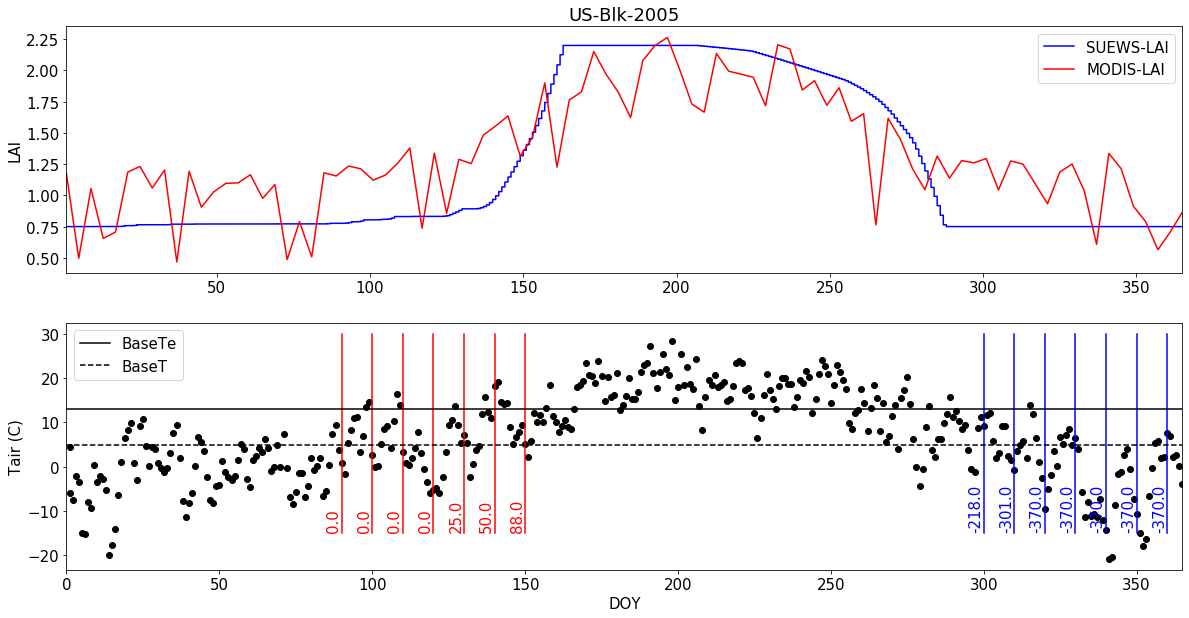

In [63]:
plt.rcParams.update({'font.size': 15})
fig,axs=plt.subplots(2,1,figsize=(20,10))
ax=axs[0]
ax.plot(lai_model.DOY,lai_model.LAI,color='b',label='SUEWS-LAI')
df_period.value_mean.plot(color='r',label='MODIS-LAI',ax=ax)
ax.set_ylabel('LAI')
ax.legend()
ax.set_title(name+'-'+str(year))
ax.set_xlabel('')

ax=axs[1]
plt.scatter(Tair.DOY,Tair.Tair,color='k')


max_y=30
for gdd_day in [90,100,110,120,130,140,150]:
    a=GDD_model[GDD_model.DOY==gdd_day].GDD1_g
    plt.plot([gdd_day,gdd_day],[-15,max_y],color='r')
    plt.annotate(str(np.round(a.values[0],0)),(gdd_day-5,-14),color='r',rotation=90)


for sdd_day in [300,310,320,330,340,350,360]:
    a=SDD_model[SDD_model.DOY==sdd_day].GDD2_s
    plt.plot([sdd_day,sdd_day],[-15,max_y],color='b')
    plt.annotate(str(np.round(a.values[0],0)),(sdd_day-5,-14),color='b',rotation=90)

ax.plot([0,365],[df_state_init.basete.iloc[0][0],df_state_init.basete.iloc[0][0]],label='BaseTe',color='k')
ax.plot([0,365],[df_state_init.baset.iloc[0][0],df_state_init.baset.iloc[0][0]],'--k',label='BaseT')
ax.legend()
plt.ylabel('Tair (C)')
plt.xlabel('DOY')
ax.set_xlim(left=0,right=365)

# To Test



US-Blk-2004


/anaconda3/envs/fiona_problem/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/envs/fiona_problem/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


US-Blk-2006


/anaconda3/envs/fiona_problem/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/envs/fiona_problem/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


US-Blk-2008


/anaconda3/envs/fiona_problem/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/envs/fiona_problem/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


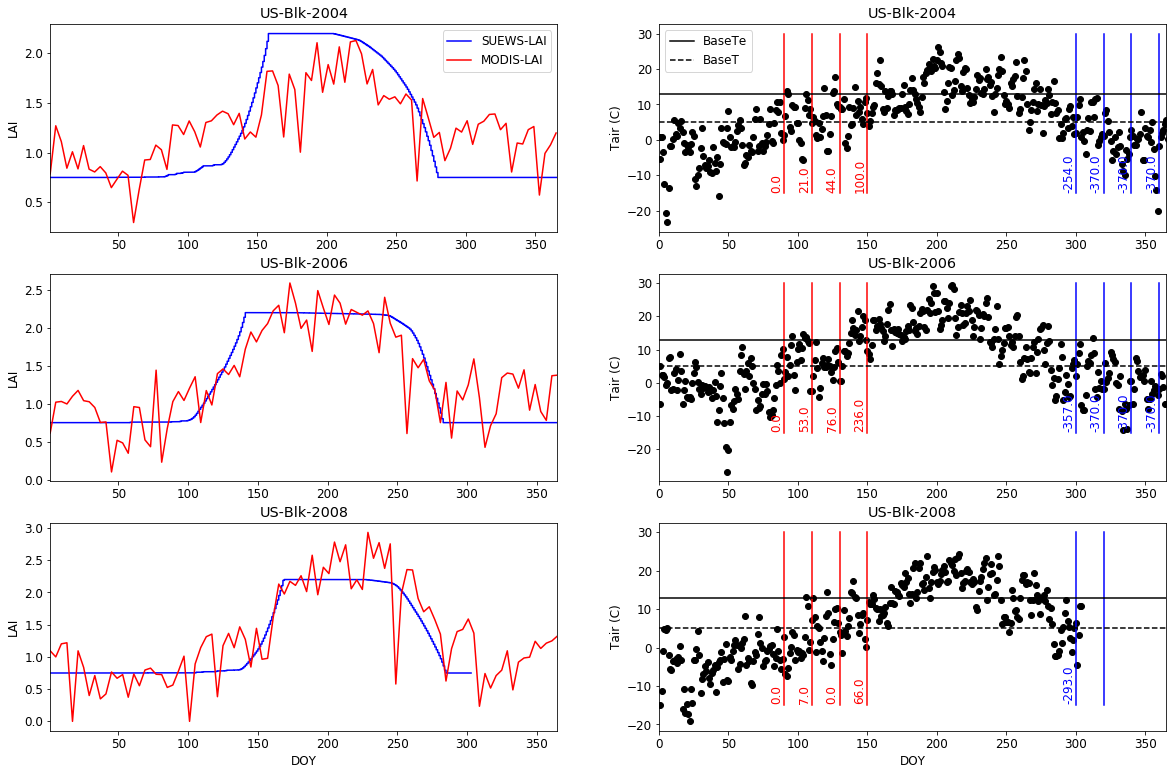

In [64]:
name='US-Blk'
years=[2004,2006,2008]

plt.rcParams.update({'font.size': 12})
fig,axs=plt.subplots(len(years),2,figsize=(20,13))

#plt.tight_layout()

counter=-1
for year in years:
    print(name+'-'+str(year))
    counter=counter+1
    df_output,df_state_final,df_state_init,df_period,grid,df_forcing_run = read_data(year,name)
    lai_model,GDD_model,SDD_model,Tair=calc_vars(df_output,grid,df_forcing_run)
    

    
    ax=axs[counter][0]
    ax.plot(lai_model.DOY,lai_model.LAI,color='b',label='SUEWS-LAI')
    df_period.value_mean.plot(color='r',label='MODIS-LAI',ax=ax)
    ax.set_ylabel('LAI')
    if counter==0:
        ax.legend()
    if counter!=len(years)-1:
        ax.set_xlabel('')
    ax.set_title(name+'-'+str(year))
    
    
    
    
    ax=axs[counter][1]
    ax.scatter(Tair.DOY,Tair.Tair,color='k')

    max_y=30
    for gdd_day in [90,110,130,150]:
        a=GDD_model[GDD_model.DOY==gdd_day].GDD1_g
        ax.plot([gdd_day,gdd_day],[-15,max_y],color='r')
        ax.annotate(str(np.round(a.values[0],0)),(gdd_day-10,-14),color='r',rotation=90)

    try:
        for sdd_day in [300,320,340,360]:
            a=SDD_model[SDD_model.DOY==sdd_day].GDD2_s
            ax.plot([sdd_day,sdd_day],[-15,max_y],color='b')
            ax.annotate(str(np.round(a.values[0],0)),(sdd_day-10,-14),color='b',rotation=90)
    except:
        pass

    ax.plot([0,365],[df_state_init.basete.iloc[0][0],df_state_init.basete.iloc[0][0]],label='BaseTe',color='k')
    ax.plot([0,365],[df_state_init.baset.iloc[0][0],df_state_init.baset.iloc[0][0]],'--k',label='BaseT')
    if counter==0:
        ax.legend()
    ax.set_ylabel('Tair (C)')
    if counter==len(years)-1:
        ax.set_xlabel('DOY')
    ax.set_xlim(left=0,right=365)
    ax.set_title(name+'-'+str(year))

plt.savefig('figs/'+name+'-LAI.png',dpi=300,bbox_inches = 'tight',pad_inches = 0.01)

# Ca-Obs-2003 Tuning

/anaconda3/envs/fiona_problem/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/envs/fiona_problem/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(0, 365)

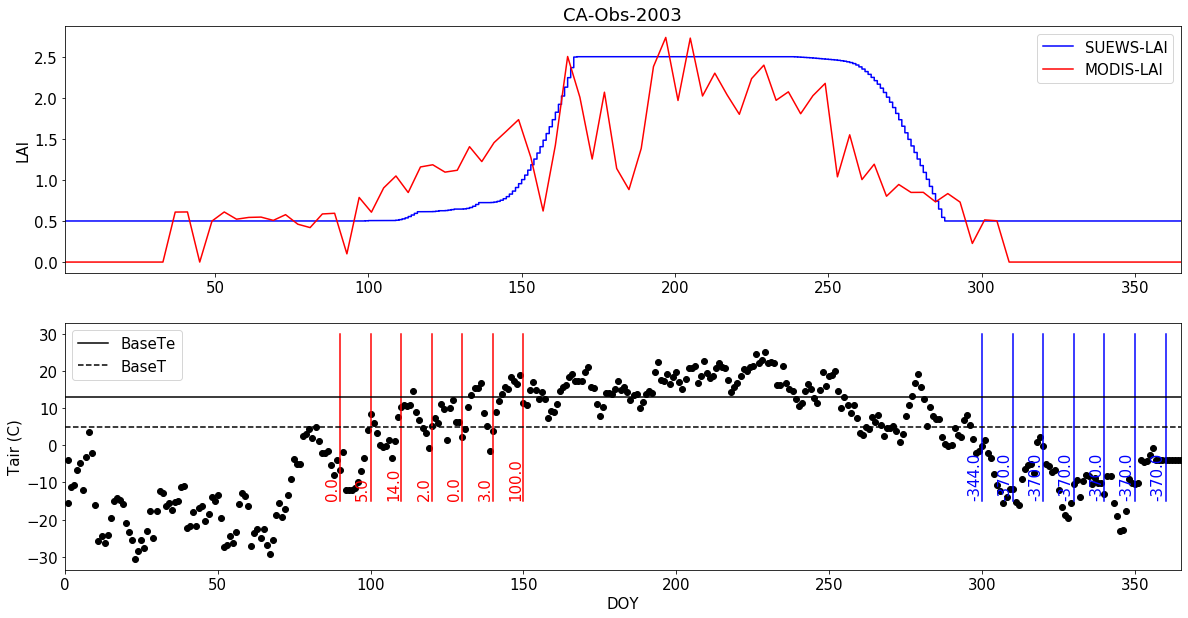

In [48]:
def modify_attr(df_state_init,df):
    df_state_init.loc[:,'emissionsmethod']=0
    df_state_init.loc[:,'sfr']=[0.0, #Paved
                            0.0, #Bldg
                            1.0, #EveTr
                            0.0, #DecTr
                            0.0, #Grass
                            0.0, #Bsoil
                            0.0] #Water
    df_state_init.loc[:,'lat']=df.Latitude.values[0].values[0]
    df_state_init.loc[:,'lng']=df.Longitude.values[0].values[0]
    
    df_state_init.loc[:,'laimin']=[0.5,0.5,1.6]
    df_state_init.loc[:,'laimax']=[2.5,5,5.9]
    df_state_init.loc[:,'gddfull']=[450,450,450]
    df_state_init.loc[:,'sddfull']=[-370,-370,-370]
    df_state_init.loc[:,'basete']=[13,13,13]
    df_state_init.loc[:,'baset']=[5,5,5]
    
    df_state_init.lai_id = df_state_init.loc[:,'laimin']
    
    return df_state_init

name='CA-Obs'
year=2003

df_output,df_state_final,df_state_init,df_period,grid,df_forcing_run = read_data(year,name)
lai_model,GDD_model,SDD_model,Tair=calc_vars(df_output,grid,df_forcing_run)

plt.rcParams.update({'font.size': 15})
fig,axs=plt.subplots(2,1,figsize=(20,10))
ax=axs[0]
ax.plot(lai_model.DOY,lai_model.LAI,color='b',label='SUEWS-LAI')
df_period.value_mean.plot(color='r',label='MODIS-LAI',ax=ax)
ax.set_ylabel('LAI')
ax.legend()
ax.set_title(name+'-'+str(year))
ax.set_xlabel('')

ax=axs[1]
plt.scatter(Tair.DOY,Tair.Tair,color='k')


max_y=30
for gdd_day in [90,100,110,120,130,140,150]:
    a=GDD_model[GDD_model.DOY==gdd_day].GDD1_g
    plt.plot([gdd_day,gdd_day],[-15,max_y],color='r')
    plt.annotate(str(np.round(a.values[0],0)),(gdd_day-5,-14),color='r',rotation=90)


for sdd_day in [300,310,320,330,340,350,360]:
    a=SDD_model[SDD_model.DOY==sdd_day].GDD2_s
    plt.plot([sdd_day,sdd_day],[-15,max_y],color='b')
    plt.annotate(str(np.round(a.values[0],0)),(sdd_day-5,-14),color='b',rotation=90)

ax.plot([0,365],[df_state_init.basete.iloc[0][0],df_state_init.basete.iloc[0][0]],label='BaseTe',color='k')
ax.plot([0,365],[df_state_init.baset.iloc[0][0],df_state_init.baset.iloc[0][0]],'--k',label='BaseT')
ax.legend()
plt.ylabel('Tair (C)')
plt.xlabel('DOY')
ax.set_xlim(left=0,right=365)

# To test

CA-Obs-2005


/anaconda3/envs/fiona_problem/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/envs/fiona_problem/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


CA-Obs-2006


/anaconda3/envs/fiona_problem/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/envs/fiona_problem/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


CA-Obs-2008


/anaconda3/envs/fiona_problem/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/envs/fiona_problem/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


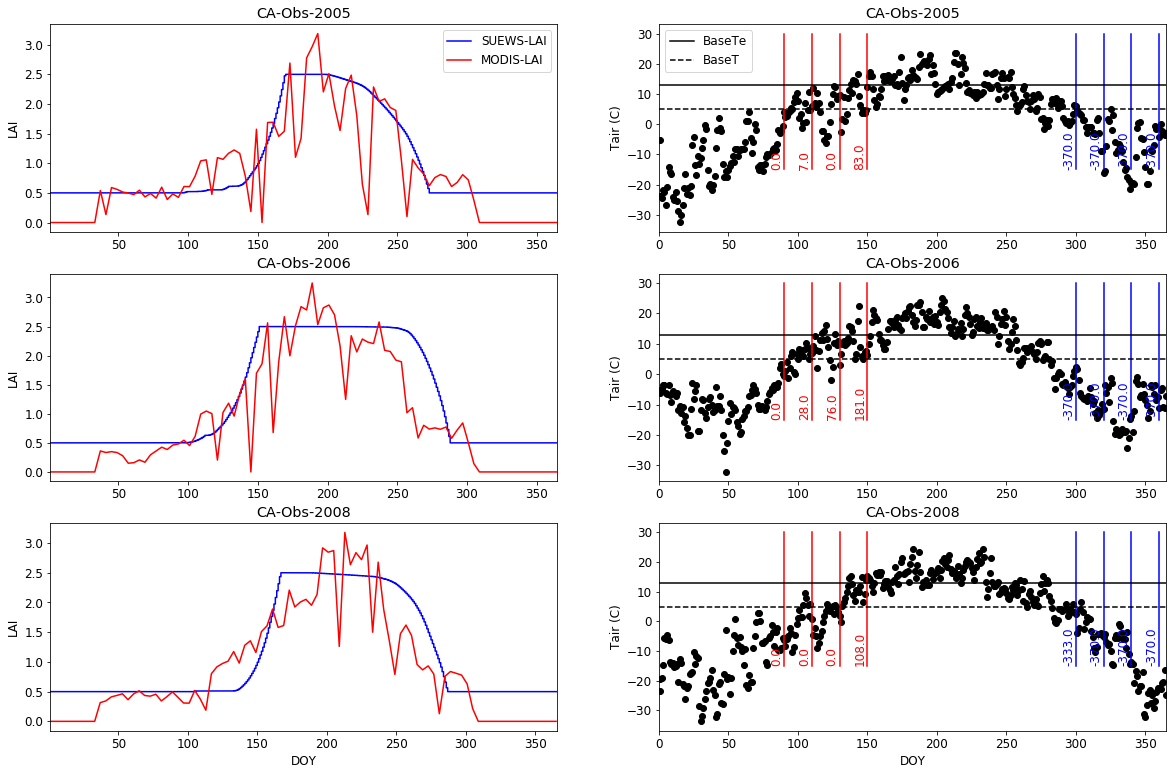

In [49]:
name='CA-Obs'
years=[2005,2006,2008]

plt.rcParams.update({'font.size': 12})
fig,axs=plt.subplots(len(years),2,figsize=(20,13))


counter=-1
for year in years:
    print(name+'-'+str(year))
    counter=counter+1
    df_output,df_state_final,df_state_init,df_period,grid,df_forcing_run = read_data(year,name)
    
    lai_model,GDD_model,SDD_model,Tair=calc_vars(df_output,grid,df_forcing_run)
    

    
    ax=axs[counter][0]
    ax.plot(lai_model.DOY,lai_model.LAI,color='b',label='SUEWS-LAI')
    df_period.value_mean.plot(color='r',label='MODIS-LAI',ax=ax)
    ax.set_ylabel('LAI')
    if counter==0:
        ax.legend()
    if counter!=len(years)-1:
        ax.set_xlabel('')
    ax.set_title(name+'-'+str(year))
    
    
    
    
    ax=axs[counter][1]
    ax.scatter(Tair.DOY,Tair.Tair,color='k')

    max_y=30
    for gdd_day in [90,110,130,150]:
        a=GDD_model[GDD_model.DOY==gdd_day].GDD1_g
        ax.plot([gdd_day,gdd_day],[-15,max_y],color='r')
        ax.annotate(str(np.round(a.values[0],0)),(gdd_day-10,-14),color='r',rotation=90)


    for sdd_day in [300,320,340,360]:
        a=SDD_model[SDD_model.DOY==sdd_day].GDD2_s
        ax.plot([sdd_day,sdd_day],[-15,max_y],color='b')
        ax.annotate(str(np.round(a.values[0],0)),(sdd_day-10,-14),color='b',rotation=90)

    ax.plot([0,365],[df_state_init.basete.iloc[0][0],df_state_init.basete.iloc[0][0]],label='BaseTe',color='k')
    ax.plot([0,365],[df_state_init.baset.iloc[0][0],df_state_init.baset.iloc[0][0]],'--k',label='BaseT')
    if counter==0:
        ax.legend()
    ax.set_ylabel('Tair (C)')
    if counter==len(years)-1:
        ax.set_xlabel('DOY')
    ax.set_xlim(left=0,right=365)
    ax.set_title(name+'-'+str(year))
    
plt.savefig('figs/'+name+'-LAI.png',dpi=300,bbox_inches = 'tight',pad_inches = 0.01)

# CA-Qcu-2005 Tuning

/anaconda3/envs/fiona_problem/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/envs/fiona_problem/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(0, 365)

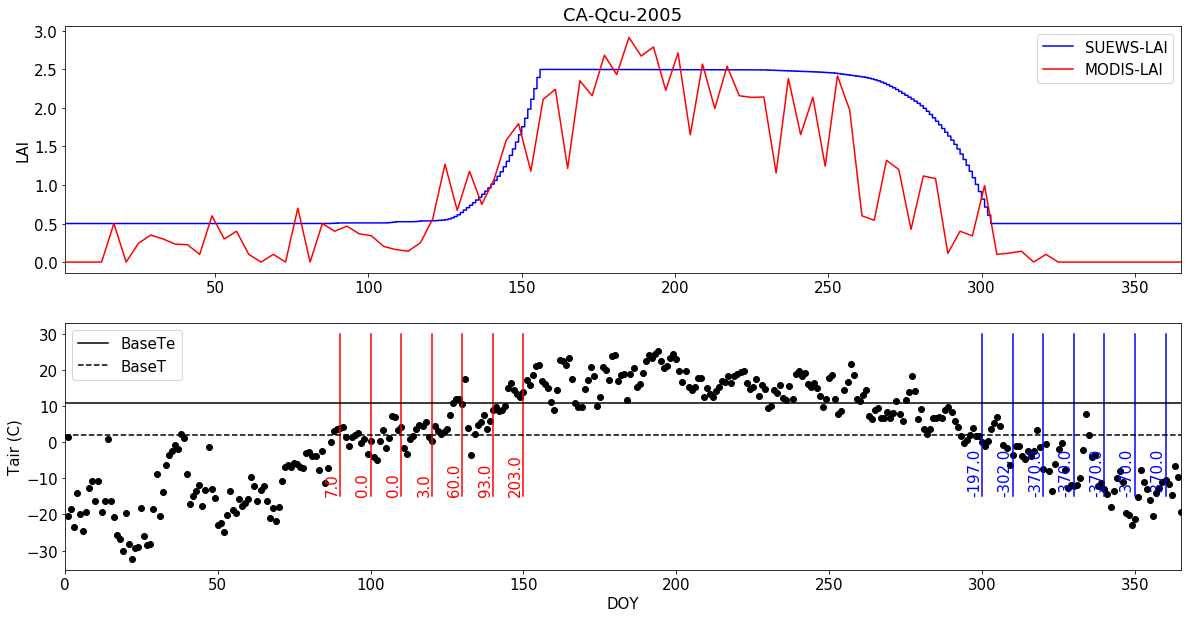

In [55]:
def modify_attr(df_state_init,df):
    df_state_init.loc[:,'emissionsmethod']=0
    df_state_init.loc[:,'sfr']=[0.0, #Paved
                            0.0, #Bldg
                            1.0, #EveTr
                            0.0, #DecTr
                            0.0, #Grass
                            0.0, #Bsoil
                            0.0] #Water
    df_state_init.loc[:,'lat']=df.Latitude.values[0].values[0]
    df_state_init.loc[:,'lng']=df.Longitude.values[0].values[0]
    
    df_state_init.loc[:,'laimin']=[0.5,0.5,1.6]
    df_state_init.loc[:,'laimax']=[2.5,5,5.9]
    df_state_init.loc[:,'gddfull']=[450,450,450]
    df_state_init.loc[:,'sddfull']=[-370,-370,-370]
    df_state_init.loc[:,'basete']=[11,11,11]
    df_state_init.loc[:,'baset']=[2,2,2]
    
    df_state_init.lai_id = df_state_init.loc[:,'laimin']
    
    return df_state_init

name='CA-Qcu'
year=2005

df_output,df_state_final,df_state_init,df_period,grid,df_forcing_run = read_data(year,name)
lai_model,GDD_model,SDD_model,Tair=calc_vars(df_output,grid,df_forcing_run)

plt.rcParams.update({'font.size': 15})
fig,axs=plt.subplots(2,1,figsize=(20,10))
ax=axs[0]
ax.plot(lai_model.DOY,lai_model.LAI,color='b',label='SUEWS-LAI')
df_period.value_mean.plot(color='r',label='MODIS-LAI',ax=ax)
ax.set_ylabel('LAI')
ax.legend()
ax.set_title(name+'-'+str(year))
ax.set_xlabel('')

ax=axs[1]
plt.scatter(Tair.DOY,Tair.Tair,color='k')


max_y=30
for gdd_day in [90,100,110,120,130,140,150]:
    a=GDD_model[GDD_model.DOY==gdd_day].GDD1_g
    plt.plot([gdd_day,gdd_day],[-15,max_y],color='r')
    plt.annotate(str(np.round(a.values[0],0)),(gdd_day-5,-14),color='r',rotation=90)


for sdd_day in [300,310,320,330,340,350,360]:
    a=SDD_model[SDD_model.DOY==sdd_day].GDD2_s
    plt.plot([sdd_day,sdd_day],[-15,max_y],color='b')
    plt.annotate(str(np.round(a.values[0],0)),(sdd_day-5,-14),color='b',rotation=90)

ax.plot([0,365],[df_state_init.basete.iloc[0][0],df_state_init.basete.iloc[0][0]],label='BaseTe',color='k')
ax.plot([0,365],[df_state_init.baset.iloc[0][0],df_state_init.baset.iloc[0][0]],'--k',label='BaseT')
ax.legend()
plt.ylabel('Tair (C)')
plt.xlabel('DOY')
ax.set_xlim(left=0,right=365)

# To Test

CA-Qcu-2008


/anaconda3/envs/fiona_problem/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/envs/fiona_problem/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


CA-Qcu-2009


/anaconda3/envs/fiona_problem/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/envs/fiona_problem/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


CA-Qcu-2010


/anaconda3/envs/fiona_problem/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/envs/fiona_problem/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


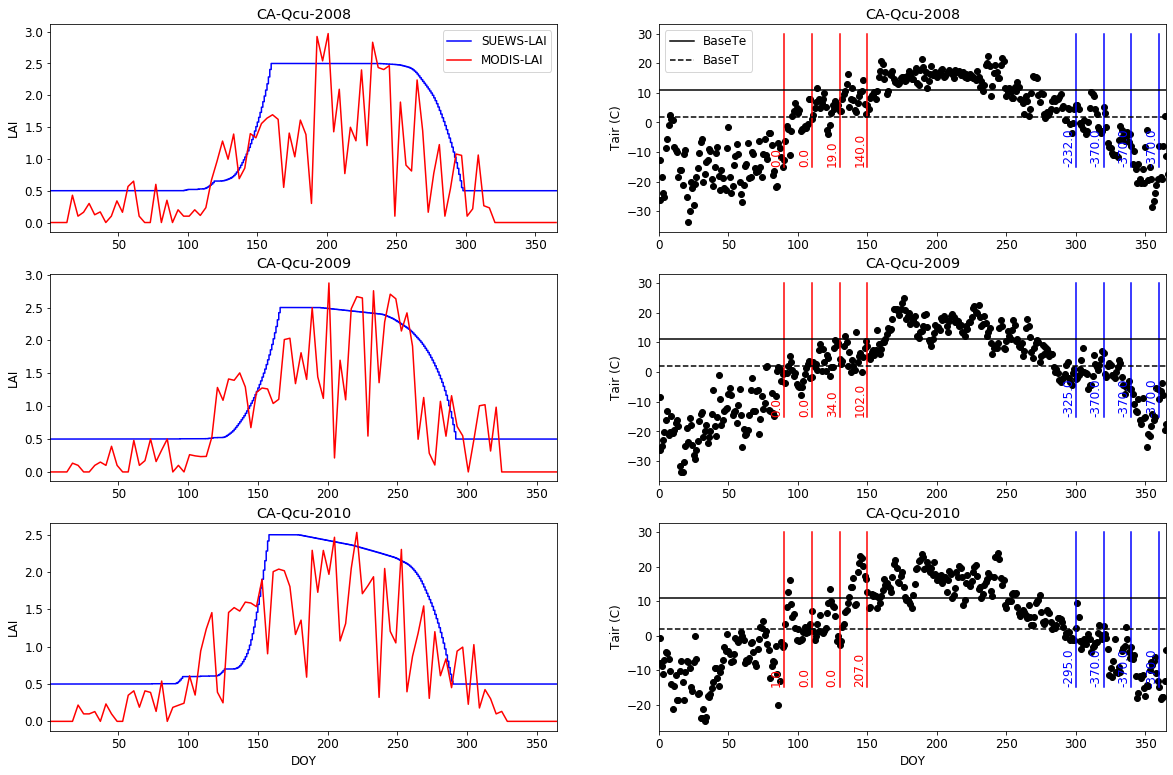

In [56]:
name='CA-Qcu'
years=[2008,2009,2010]

plt.rcParams.update({'font.size': 12})
fig,axs=plt.subplots(len(years),2,figsize=(20,13))


counter=-1
for year in years:
    print(name+'-'+str(year))
    counter=counter+1
    df_output,df_state_final,df_state_init,df_period,grid,df_forcing_run = read_data(year,name)
    
    lai_model,GDD_model,SDD_model,Tair=calc_vars(df_output,grid,df_forcing_run)
    

    
    ax=axs[counter][0]
    ax.plot(lai_model.DOY,lai_model.LAI,color='b',label='SUEWS-LAI')
    df_period.value_mean.plot(color='r',label='MODIS-LAI',ax=ax)
    ax.set_ylabel('LAI')
    if counter==0:
        ax.legend()
    if counter!=len(years)-1:
        ax.set_xlabel('')
    ax.set_title(name+'-'+str(year))
    
    
    
    
    ax=axs[counter][1]
    ax.scatter(Tair.DOY,Tair.Tair,color='k')

    max_y=30
    for gdd_day in [90,110,130,150]:
        a=GDD_model[GDD_model.DOY==gdd_day].GDD1_g
        ax.plot([gdd_day,gdd_day],[-15,max_y],color='r')
        ax.annotate(str(np.round(a.values[0],0)),(gdd_day-10,-14),color='r',rotation=90)


    for sdd_day in [300,320,340,360]:
        a=SDD_model[SDD_model.DOY==sdd_day].GDD2_s
        ax.plot([sdd_day,sdd_day],[-15,max_y],color='b')
        ax.annotate(str(np.round(a.values[0],0)),(sdd_day-10,-14),color='b',rotation=90)

    ax.plot([0,365],[df_state_init.basete.iloc[0][0],df_state_init.basete.iloc[0][0]],label='BaseTe',color='k')
    ax.plot([0,365],[df_state_init.baset.iloc[0][0],df_state_init.baset.iloc[0][0]],'--k',label='BaseT')
    if counter==0:
        ax.legend()
    ax.set_ylabel('Tair (C)')
    if counter==len(years)-1:
        ax.set_xlabel('DOY')
    ax.set_xlim(left=0,right=365)
    ax.set_title(name+'-'+str(year))

plt.savefig('figs/'+name+'-LAI.png',dpi=300,bbox_inches = 'tight',pad_inches = 0.01)